In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import Model
from keras import Input
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


In [10]:
# set up training set
#view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_imp_fatal_cvd_patched_100096inds.feather")

print(view_1hot_df.columns)
print(view_1hot_df.shape)

print(view_1hot_df['CVD_ISOSORBRIDE_DINITRATE'].unique())
view_1hot_df = view_1hot_df.drop(['CVD_ISOSORBRIDE_DINITRATE'], axis=1)
print(view_1hot_df.shape)
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set length to 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']!=0])
print(view_1hot_df.shape[0]/28)
# Take 90000 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), :-7].values)
print(train_v.shape)
print(train_v.shape[0]/28)

# set up test set
#test_df = feather.read_dataframe("/home/whsu014/data/Test_set_with_TRUE_10096inds.feather")
test_df = feather.read_dataframe("/home/whsu014/data/test_imp_fatal_cvd_patched_10096inds.feather")
print(test_df.columns)
print(test_df.shape)
print("Number of inds:", len(test_df['VSIMPLE_INDEX_MASTER'].unique()))
test_v = copy.deepcopy(test_df.iloc[:, :-7].values)

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=191)
(2902784, 191)
[0.]
(2902784, 190)
Number of inds: 100096
100096.0
100096.0
(2520000, 182)
90000.0
Index(['VSIMPLE_INDEX_MASTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1', 'ETHN_2',
       'ETHN_3', 'ETHN_4', 'ETHN_5', 'TEST',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=189)
(282688, 189)
Number of inds: 10096


In [11]:
# This block removes the prediction window 
# from the train and test set before scaling

print(train_v.shape)
num_of_inds = train_v.shape[0]//28
num_of_features = train_v.shape[1]
print("Number of inds (train) :{}".format(num_of_inds))
print("Number of features (train) :{}".format(num_of_features))

train_ = np.empty((num_of_inds*8, train_v.shape[1]))
for i in range(num_of_inds):
    ind_v = train_v[(i*28):((i+1)*28), :]
    train_[(i*8):((i+1)*8), :] = ind_v[:8, :]
print(train_.shape)
print(train_.shape[0]/8)

print()

print(test_v.shape)
num_of_inds = test_v.shape[0]//28
num_of_features = test_v.shape[1]
print("Number of inds (test): {}".format(num_of_inds))
print("Number of features (test): {}".format(num_of_features))

test_ = np.empty((num_of_inds*8, test_v.shape[1]))
for i in range(num_of_inds):
    ind_v = test_v[(i*28):((i+1)*28), :]
    test_[(i*8):((i+1)*8), :] = ind_v[:8, :]
print(test_.shape)
print(test_.shape[0]/8)

(2520000, 182)
Number of inds (train) :90000
Number of features (train) :182
(720000, 182)
90000.0

(282688, 182)
Number of inds (test): 10096
Number of features (test): 182
(80768, 182)
10096.0


In [12]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_) 
scaled_test = scaler.transform(test_)

In [13]:
print('LL_PDC:', view_1hot_df.columns.get_loc('LL_PDC'))
print()
print("Number of days:", view_1hot_df.columns.get_loc('NUMBER_OF_DAYS'))
print("Acute adm:", view_1hot_df.columns.get_loc('ACUTE_ADM'))
print("Mortality broad cvd with other:", view_1hot_df.columns.get_loc('mortality_broad_cvd_with_other'))
print("out broad_cvd:", view_1hot_df.columns.get_loc('out_broad_cvd'))
print("out atrial fibrillation:", view_1hot_df.columns.get_loc('out_atrial_fibrillation'))
print("PT IMP FATAL CVD:", view_1hot_df.columns.get_loc('PT_IMP_FATAL_CVD'))

LL_PDC: 28

Number of days: 120
Acute adm: 121
Mortality broad cvd with other: 143
out broad_cvd: 145
out atrial fibrillation: 162
PT IMP FATAL CVD: 181


In [14]:
def setup_xy(time_series_v, scaled_time_series):
    num_of_inds = time_series_v.shape[0]//28
    print("Number of inds:", num_of_inds)
    num_of_features = time_series_v.shape[1]
    print("Number of features:", num_of_features)
    ##############################
    # make Adherence x and y
    ##############################
    x_v = np.empty((num_of_inds, 8, num_of_features))
    for i in range(num_of_inds):
        scaled_ind_v = scaled_time_series[(i*8):((i+1)*8), :]
        x_v[i] = scaled_ind_v[:8, :]
    ##############################
    # creating 2 binary vectors for softmax 
    # non-adherent and adherent
    ##############################
    y_pdc_v = np.empty((num_of_inds, 2))
    for i in range(num_of_inds):
        ind_v = time_series_v[(i*28):((i+1)*28), :]
        if sum(ind_v[8:28, 28])/20 >= 80:
            y_pdc_v[i, 0] = 0.0
            y_pdc_v[i, 1] = 1.0
        else:
            y_pdc_v[i, 0] = 1.0
            y_pdc_v[i, 1] = 0.0
    ##############################
    # creating 2 binary vectors for softmax 
    # no-event and event
    ##############################
    y_event_v = np.empty((num_of_inds, 2))
    for i in range(num_of_inds):
        ind_v = time_series_v[(i*28):((i+1)*28), :]
        event = False
        for j in range(8, 28):
            if ind_v[j, 121] == 1.0 and \
                1.0 in ind_v[j, 143:162]:  # it is an acute CVD event (Atrial fibrillation is not a CVD event)
                event = True
            if 1.0 in ind_v[8:, 181]:
                event = True
        if event:
            y_event_v[i, :] = np.array([0.0, 1.0])
        else:
            y_event_v[i, :] = np.array([1.0, 0.0])
    print("Number of individuals who are adherent", \
          sum(y_pdc_v[:, 1]))
    print("Number of individuals who are not adherent", \
          sum(y_pdc_v[:, 0]))
    print("Number of individuals who had a CVD event:", \
          sum(y_event_v[:, 1]))
    print("Event ratio:", sum(y_event_v[:, 1])/num_of_inds)
    return x_v, y_pdc_v, y_event_v

In [15]:
x_train, y_pdc_train, y_event_train = setup_xy(train_v, scaled_train)
x_test, y_pdc_test, y_event_test = setup_xy(test_v, scaled_test)
print(x_train.shape)
print(y_pdc_train.shape)
print(y_event_train.shape)
print()
print(x_test.shape)
print(y_pdc_test.shape)
print(y_event_test.shape)

Number of inds: 90000
Number of features: 182
Number of individuals who are adherent 51911.0
Number of individuals who are not adherent 38089.0
Number of individuals who had a CVD event: 10945.0
Event ratio: 0.12161111111111111
Number of inds: 10096
Number of features: 182
Number of individuals who are adherent 5757.0
Number of individuals who are not adherent 4339.0
Number of individuals who had a CVD event: 1286.0
Event ratio: 0.12737717908082408
(90000, 8, 182)
(90000, 2)
(90000, 2)

(10096, 8, 182)
(10096, 2)
(10096, 2)


9000
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 1s - loss: 4.2958 - pdc_loss: 0.6925 - event_loss: 0.7644 - val_loss: 3.9825 - val_pdc_loss: 0.6826 - val_event_loss: 0.7239

Epoch 00001: val_loss improved from inf to 3.98253, saving model to Event_val_weights1.hdf5
Epoch 2/500
 - 1s - loss: 3.7514 - pdc_loss: 0.6677 - event_loss: 0.7010 - val_loss: 3.4870 - val_pdc_loss: 0.6620 - val_event_loss: 0.6727

Epoch 00002: val_loss improved from 3.98253 to 3.48700, saving model to Event_val_weights1.hdf5
Epoch 3/500
 - 1s - loss: 3.2933 - pdc_loss: 0.6494 - event_loss: 0.6595 - val_loss: 3.0705 - val_pdc_loss: 0.6462 - val_event_loss: 0.6388

Epoch 00003: val_loss improved from 3.48700 to 3.07054, saving model to Event_val_weights1.hdf5
Epoch 4/500
 - 1s - loss: 2.9100 - pdc_loss: 0.6351 - event_loss: 0.6328 - val_loss: 2.7226 - val_pdc_loss: 0.6331 - val_event_loss: 0.6168

Epoch 00004: val_loss improved from 3.07054 to 2.72262, saving model to Event_val_weights1.hdf5
Ep


Epoch 00035: val_loss improved from 1.08780 to 1.08752, saving model to Event_val_weights1.hdf5
Epoch 36/500
 - 1s - loss: 1.0872 - pdc_loss: 0.5384 - event_loss: 0.5345 - val_loss: 1.0865 - val_pdc_loss: 0.5423 - val_event_loss: 0.5299

Epoch 00036: val_loss improved from 1.08752 to 1.08646, saving model to Event_val_weights1.hdf5
Epoch 37/500
 - 1s - loss: 1.0863 - pdc_loss: 0.5379 - event_loss: 0.5343 - val_loss: 1.0861 - val_pdc_loss: 0.5419 - val_event_loss: 0.5301

Epoch 00037: val_loss improved from 1.08646 to 1.08609, saving model to Event_val_weights1.hdf5
Epoch 38/500
 - 1s - loss: 1.0855 - pdc_loss: 0.5374 - event_loss: 0.5341 - val_loss: 1.0857 - val_pdc_loss: 0.5415 - val_event_loss: 0.5303

Epoch 00038: val_loss improved from 1.08609 to 1.08566, saving model to Event_val_weights1.hdf5
Epoch 39/500
 - 1s - loss: 1.0846 - pdc_loss: 0.5369 - event_loss: 0.5338 - val_loss: 1.0850 - val_pdc_loss: 0.5411 - val_event_loss: 0.5300

Epoch 00039: val_loss improved from 1.08566 to 

 - 1s - loss: 1.0690 - pdc_loss: 0.5286 - event_loss: 0.5288 - val_loss: 1.0783 - val_pdc_loss: 0.5349 - val_event_loss: 0.5319

Epoch 00073: val_loss improved from 1.07841 to 1.07829, saving model to Event_val_weights1.hdf5
Epoch 74/500
 - 1s - loss: 1.0687 - pdc_loss: 0.5285 - event_loss: 0.5287 - val_loss: 1.0780 - val_pdc_loss: 0.5348 - val_event_loss: 0.5318

Epoch 00074: val_loss improved from 1.07829 to 1.07801, saving model to Event_val_weights1.hdf5
Epoch 75/500
 - 1s - loss: 1.0685 - pdc_loss: 0.5284 - event_loss: 0.5286 - val_loss: 1.0780 - val_pdc_loss: 0.5346 - val_event_loss: 0.5319

Epoch 00075: val_loss improved from 1.07801 to 1.07799, saving model to Event_val_weights1.hdf5
Epoch 76/500
 - 1s - loss: 1.0682 - pdc_loss: 0.5283 - event_loss: 0.5285 - val_loss: 1.0781 - val_pdc_loss: 0.5346 - val_event_loss: 0.5321

Epoch 00076: val_loss did not improve from 1.07799
Epoch 77/500
 - 1s - loss: 1.0681 - pdc_loss: 0.5282 - event_loss: 0.5286 - val_loss: 1.0774 - val_pdc_los

 - 1s - loss: 1.0612 - pdc_loss: 0.5250 - event_loss: 0.5262 - val_loss: 1.0745 - val_pdc_loss: 0.5314 - val_event_loss: 0.5331

Epoch 00112: val_loss did not improve from 1.07433
Epoch 113/500
 - 1s - loss: 1.0612 - pdc_loss: 0.5250 - event_loss: 0.5262 - val_loss: 1.0746 - val_pdc_loss: 0.5313 - val_event_loss: 0.5333

Epoch 00113: val_loss did not improve from 1.07433
Epoch 114/500
 - 1s - loss: 1.0610 - pdc_loss: 0.5249 - event_loss: 0.5262 - val_loss: 1.0749 - val_pdc_loss: 0.5313 - val_event_loss: 0.5337

Epoch 00114: val_loss did not improve from 1.07433
Epoch 115/500
 - 1s - loss: 1.0611 - pdc_loss: 0.5250 - event_loss: 0.5262 - val_loss: 1.0746 - val_pdc_loss: 0.5314 - val_event_loss: 0.5332

Epoch 00115: val_loss did not improve from 1.07433
Epoch 116/500
 - 1s - loss: 1.0609 - pdc_loss: 0.5248 - event_loss: 0.5262 - val_loss: 1.0750 - val_pdc_loss: 0.5313 - val_event_loss: 0.5338

Epoch 00116: val_loss did not improve from 1.07433
Epoch 117/500
 - 1s - loss: 1.0609 - pdc_los


Epoch 00152: val_loss did not improve from 1.07215
Epoch 153/500
 - 1s - loss: 1.0573 - pdc_loss: 0.5233 - event_loss: 0.5251 - val_loss: 1.0732 - val_pdc_loss: 0.5298 - val_event_loss: 0.5344

Epoch 00153: val_loss did not improve from 1.07215
Epoch 154/500
 - 1s - loss: 1.0572 - pdc_loss: 0.5232 - event_loss: 0.5250 - val_loss: 1.0728 - val_pdc_loss: 0.5299 - val_event_loss: 0.5340

Epoch 00154: val_loss did not improve from 1.07215
Epoch 155/500
 - 1s - loss: 1.0573 - pdc_loss: 0.5232 - event_loss: 0.5251 - val_loss: 1.0737 - val_pdc_loss: 0.5297 - val_event_loss: 0.5350

Epoch 00155: val_loss did not improve from 1.07215
Epoch 156/500
 - 1s - loss: 1.0571 - pdc_loss: 0.5231 - event_loss: 0.5250 - val_loss: 1.0724 - val_pdc_loss: 0.5298 - val_event_loss: 0.5337

Epoch 00156: val_loss did not improve from 1.07215
Epoch 157/500
 - 1s - loss: 1.0571 - pdc_loss: 0.5232 - event_loss: 0.5250 - val_loss: 1.0728 - val_pdc_loss: 0.5298 - val_event_loss: 0.5340

Epoch 00157: val_loss did not

 - 1s - loss: 1.0548 - pdc_loss: 0.5223 - event_loss: 0.5240 - val_loss: 1.0746 - val_pdc_loss: 0.5299 - val_event_loss: 0.5363

Epoch 00195: val_loss did not improve from 1.07215
Epoch 196/500
 - 1s - loss: 1.0548 - pdc_loss: 0.5223 - event_loss: 0.5240 - val_loss: 1.0738 - val_pdc_loss: 0.5299 - val_event_loss: 0.5355

Epoch 00196: val_loss did not improve from 1.07215
Epoch 197/500
 - 1s - loss: 1.0548 - pdc_loss: 0.5222 - event_loss: 0.5241 - val_loss: 1.0742 - val_pdc_loss: 0.5298 - val_event_loss: 0.5359

Epoch 00197: val_loss did not improve from 1.07215
Epoch 198/500
 - 1s - loss: 1.0547 - pdc_loss: 0.5222 - event_loss: 0.5239 - val_loss: 1.0753 - val_pdc_loss: 0.5297 - val_event_loss: 0.5371

Epoch 00198: val_loss did not improve from 1.07215
Epoch 199/500
 - 1s - loss: 1.0547 - pdc_loss: 0.5221 - event_loss: 0.5240 - val_loss: 1.0748 - val_pdc_loss: 0.5297 - val_event_loss: 0.5365

Epoch 00199: val_loss did not improve from 1.07215
Epoch 200/500
 - 1s - loss: 1.0545 - pdc_los


Epoch 00237: val_loss did not improve from 1.07215
Epoch 238/500
 - 1s - loss: 1.0534 - pdc_loss: 0.5220 - event_loss: 0.5230 - val_loss: 1.0771 - val_pdc_loss: 0.5299 - val_event_loss: 0.5388

Epoch 00238: val_loss did not improve from 1.07215
Epoch 239/500
 - 1s - loss: 1.0535 - pdc_loss: 0.5221 - event_loss: 0.5231 - val_loss: 1.0761 - val_pdc_loss: 0.5296 - val_event_loss: 0.5381

Epoch 00239: val_loss did not improve from 1.07215
Epoch 240/500
 - 1s - loss: 1.0532 - pdc_loss: 0.5221 - event_loss: 0.5228 - val_loss: 1.0772 - val_pdc_loss: 0.5300 - val_event_loss: 0.5388

Epoch 00240: val_loss did not improve from 1.07215
Epoch 241/500
 - 1s - loss: 1.0534 - pdc_loss: 0.5221 - event_loss: 0.5229 - val_loss: 1.0755 - val_pdc_loss: 0.5297 - val_event_loss: 0.5375

Epoch 00241: val_loss did not improve from 1.07215
Epoch 242/500
 - 1s - loss: 1.0532 - pdc_loss: 0.5221 - event_loss: 0.5227 - val_loss: 1.0774 - val_pdc_loss: 0.5298 - val_event_loss: 0.5392

Epoch 00242: val_loss did not

 - 1s - loss: 1.0513 - pdc_loss: 0.5212 - event_loss: 0.5218 - val_loss: 1.0741 - val_pdc_loss: 0.5277 - val_event_loss: 0.5381

Epoch 00280: val_loss did not improve from 1.07215
Epoch 281/500
 - 1s - loss: 1.0513 - pdc_loss: 0.5212 - event_loss: 0.5218 - val_loss: 1.0735 - val_pdc_loss: 0.5272 - val_event_loss: 0.5381

Epoch 00281: val_loss did not improve from 1.07215
Epoch 282/500
 - 1s - loss: 1.0511 - pdc_loss: 0.5211 - event_loss: 0.5217 - val_loss: 1.0758 - val_pdc_loss: 0.5278 - val_event_loss: 0.5398

Epoch 00282: val_loss did not improve from 1.07215
Epoch 283/500
 - 1s - loss: 1.0513 - pdc_loss: 0.5212 - event_loss: 0.5218 - val_loss: 1.0745 - val_pdc_loss: 0.5275 - val_event_loss: 0.5386

Epoch 00283: val_loss did not improve from 1.07215
Epoch 284/500
 - 1s - loss: 1.0511 - pdc_loss: 0.5211 - event_loss: 0.5217 - val_loss: 1.0750 - val_pdc_loss: 0.5280 - val_event_loss: 0.5387

Epoch 00284: val_loss did not improve from 1.07215
Epoch 285/500
 - 1s - loss: 1.0513 - pdc_los


Epoch 00322: val_loss did not improve from 1.07215
Epoch 323/500
 - 1s - loss: 1.0499 - pdc_loss: 0.5206 - event_loss: 0.5209 - val_loss: 1.0773 - val_pdc_loss: 0.5283 - val_event_loss: 0.5407

Epoch 00323: val_loss did not improve from 1.07215
Epoch 324/500
 - 1s - loss: 1.0499 - pdc_loss: 0.5207 - event_loss: 0.5209 - val_loss: 1.0777 - val_pdc_loss: 0.5283 - val_event_loss: 0.5411

Epoch 00324: val_loss did not improve from 1.07215
Epoch 325/500
 - 1s - loss: 1.0497 - pdc_loss: 0.5205 - event_loss: 0.5209 - val_loss: 1.0756 - val_pdc_loss: 0.5278 - val_event_loss: 0.5395

Epoch 00325: val_loss did not improve from 1.07215
Epoch 326/500
 - 1s - loss: 1.0497 - pdc_loss: 0.5206 - event_loss: 0.5208 - val_loss: 1.0761 - val_pdc_loss: 0.5278 - val_event_loss: 0.5399

Epoch 00326: val_loss did not improve from 1.07215
Epoch 327/500
 - 1s - loss: 1.0497 - pdc_loss: 0.5205 - event_loss: 0.5208 - val_loss: 1.0758 - val_pdc_loss: 0.5278 - val_event_loss: 0.5397

Epoch 00327: val_loss did not

 - 1s - loss: 1.0487 - pdc_loss: 0.5201 - event_loss: 0.5201 - val_loss: 1.0784 - val_pdc_loss: 0.5291 - val_event_loss: 0.5408

Epoch 00365: val_loss did not improve from 1.07215
Epoch 366/500
 - 1s - loss: 1.0487 - pdc_loss: 0.5201 - event_loss: 0.5201 - val_loss: 1.0779 - val_pdc_loss: 0.5293 - val_event_loss: 0.5401

Epoch 00366: val_loss did not improve from 1.07215
Epoch 367/500
 - 1s - loss: 1.0485 - pdc_loss: 0.5200 - event_loss: 0.5200 - val_loss: 1.0762 - val_pdc_loss: 0.5292 - val_event_loss: 0.5386

Epoch 00367: val_loss did not improve from 1.07215
Epoch 368/500
 - 1s - loss: 1.0485 - pdc_loss: 0.5202 - event_loss: 0.5199 - val_loss: 1.0781 - val_pdc_loss: 0.5296 - val_event_loss: 0.5400

Epoch 00368: val_loss did not improve from 1.07215
Epoch 369/500
 - 1s - loss: 1.0488 - pdc_loss: 0.5202 - event_loss: 0.5201 - val_loss: 1.0762 - val_pdc_loss: 0.5290 - val_event_loss: 0.5387

Epoch 00369: val_loss did not improve from 1.07215
Epoch 370/500
 - 1s - loss: 1.0485 - pdc_los


Epoch 00407: val_loss did not improve from 1.07215
Epoch 408/500
 - 1s - loss: 1.0476 - pdc_loss: 0.5199 - event_loss: 0.5192 - val_loss: 1.0814 - val_pdc_loss: 0.5293 - val_event_loss: 0.5436

Epoch 00408: val_loss did not improve from 1.07215
Epoch 409/500
 - 1s - loss: 1.0476 - pdc_loss: 0.5199 - event_loss: 0.5191 - val_loss: 1.0816 - val_pdc_loss: 0.5294 - val_event_loss: 0.5437

Epoch 00409: val_loss did not improve from 1.07215
Epoch 410/500
 - 1s - loss: 1.0475 - pdc_loss: 0.5199 - event_loss: 0.5191 - val_loss: 1.0814 - val_pdc_loss: 0.5296 - val_event_loss: 0.5432

Epoch 00410: val_loss did not improve from 1.07215
Epoch 411/500
 - 1s - loss: 1.0475 - pdc_loss: 0.5199 - event_loss: 0.5191 - val_loss: 1.0805 - val_pdc_loss: 0.5293 - val_event_loss: 0.5426

Epoch 00411: val_loss did not improve from 1.07215
Epoch 412/500
 - 1s - loss: 1.0474 - pdc_loss: 0.5199 - event_loss: 0.5190 - val_loss: 1.0825 - val_pdc_loss: 0.5297 - val_event_loss: 0.5442

Epoch 00412: val_loss did not

 - 1s - loss: 1.0472 - pdc_loss: 0.5198 - event_loss: 0.5188 - val_loss: 1.0839 - val_pdc_loss: 0.5300 - val_event_loss: 0.5453

Epoch 00450: val_loss did not improve from 1.07215
Epoch 451/500
 - 1s - loss: 1.0464 - pdc_loss: 0.5197 - event_loss: 0.5182 - val_loss: 1.0827 - val_pdc_loss: 0.5289 - val_event_loss: 0.5453

Epoch 00451: val_loss did not improve from 1.07215
Epoch 452/500
 - 1s - loss: 1.0467 - pdc_loss: 0.5196 - event_loss: 0.5185 - val_loss: 1.0832 - val_pdc_loss: 0.5296 - val_event_loss: 0.5449

Epoch 00452: val_loss did not improve from 1.07215
Epoch 453/500
 - 1s - loss: 1.0468 - pdc_loss: 0.5198 - event_loss: 0.5184 - val_loss: 1.0825 - val_pdc_loss: 0.5293 - val_event_loss: 0.5446

Epoch 00453: val_loss did not improve from 1.07215
Epoch 454/500
 - 1s - loss: 1.0469 - pdc_loss: 0.5199 - event_loss: 0.5184 - val_loss: 1.0835 - val_pdc_loss: 0.5298 - val_event_loss: 0.5451

Epoch 00454: val_loss did not improve from 1.07215
Epoch 455/500
 - 1s - loss: 1.0469 - pdc_los


Epoch 00492: val_loss did not improve from 1.07215
Epoch 493/500
 - 1s - loss: 1.0456 - pdc_loss: 0.5195 - event_loss: 0.5175 - val_loss: 1.0834 - val_pdc_loss: 0.5285 - val_event_loss: 0.5463

Epoch 00493: val_loss did not improve from 1.07215
Epoch 494/500
 - 1s - loss: 1.0458 - pdc_loss: 0.5194 - event_loss: 0.5179 - val_loss: 1.0847 - val_pdc_loss: 0.5295 - val_event_loss: 0.5466

Epoch 00494: val_loss did not improve from 1.07215
Epoch 495/500
 - 1s - loss: 1.0457 - pdc_loss: 0.5196 - event_loss: 0.5175 - val_loss: 1.0838 - val_pdc_loss: 0.5288 - val_event_loss: 0.5464

Epoch 00495: val_loss did not improve from 1.07215
Epoch 496/500
 - 1s - loss: 1.0461 - pdc_loss: 0.5196 - event_loss: 0.5179 - val_loss: 1.0846 - val_pdc_loss: 0.5293 - val_event_loss: 0.5466

Epoch 00496: val_loss did not improve from 1.07215
Epoch 497/500
 - 1s - loss: 1.0460 - pdc_loss: 0.5197 - event_loss: 0.5177 - val_loss: 1.0850 - val_pdc_loss: 0.5290 - val_event_loss: 0.5474

Epoch 00497: val_loss did not

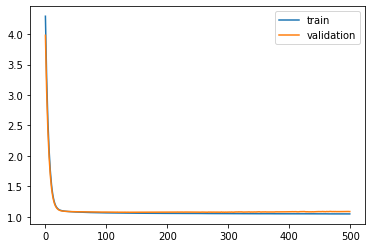

Time to train LSTM:  351.3132209777832
Entire process took:  351.4025146961212


In [18]:
num_per_fold = x_train.shape[0]//10
print(num_per_fold)

units = 8
batch_s = 8192
l2 = 0.05604813357331892

start_time = time.time()

for f in range(1):#10
    #start = f*num_per_fold
    end = (f+1)*num_per_fold
    train1_x = x_train[:end, ]
    train2_x = x_train[end:, ]
    train_x_lstm = np.append(train2_x, train1_x, axis=0) 
    train1_y_pdc = y_pdc_train[:end, ]
    train2_y_pdc = y_pdc_train[end:, ]
    train_y_pdc = np.append(train2_y_pdc, train1_y_pdc, axis=0)
    train1_y_event = y_event_train[:end, ]
    train2_y_event = y_event_train[end:, ]
    train_y_event = np.append(train2_y_event, train1_y_event, axis=0)
    start_time_inner = time.time()
    with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
        x = Input(shape=(8, 182), name="obs")
        model = CuDNNLSTM(units,
                          kernel_regularizer=regularizers.l2(l2))(x)
        out_pdc = Dense(2, activation='softmax', name="pdc")(model)
        out_event = Dense(2, activation='softmax', name="event")(model)
        multi_out_model = Model(x, outputs=[out_pdc, out_event])
        multi_out_model.compile(loss=["categorical_crossentropy",
                                    "categorical_crossentropy"],
                              #{"pdc":keras.losses.CategoricalCrossentropy(from_logit=True),\
                              #      "event":keras.losses.CategoricalCrossentropy(from_logit=True)}, 
                              optimizer='adam'
                              )  
        val_weight = "Event_val_weights" + str(f+1) + ".hdf5"
        val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                            monitor='val_loss', verbose=1,
                                            save_best_only=True)
        history = multi_out_model.fit({"obs":train_x_lstm}, 
                                      {"pdc":train_y_pdc, 
                                       "event":train_y_event},
                                       batch_size=batch_s, 
                                       epochs=500, validation_split=0.1, 
                                       callbacks=[val_checkpointer], 
                                       verbose=2, 
                                       shuffle=False,
                                       sample_weight={"pdc": class_weight.\
                                                             compute_sample_weight("balanced",
                                                                                   train_y_pdc[:, 1]),
                                                      "event":class_weight.\
                                                             compute_sample_weight("balanced",
                                                                                   train_y_event[:, 1])}
                                        )
        print("#################################")
        print("Number of units:", units)
        print("Batch size:", batch_s)
        print("Fold:", f)
        print("L2:", l2)
        print("best val loss:", min(history.history['val_loss']))
        print("#################################")
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='validation')
        pyplot.legend()
        pyplot.show()
        multi_out_model.load_weights(val_weight)
        yhat_pdc_test, yhat_event_test = multi_out_model.predict(x_test)
        end_time = time.time()
        print("Time to train LSTM: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

In [19]:
yhat_pdc_test_df = pd.DataFrame(yhat_pdc_test)
yhat_event_test_df = pd.DataFrame(yhat_event_test)
yhat_pdc_test_df.columns = ['NON_ADHERENT', 'ADHERENT']
yhat_event_test_df.columns = ['NO_EVENT', 'EVENT']
feather.write_dataframe(yhat_pdc_test_df, "/home/whsu014/data/Multi_PDC_LSTM_IFC_Patched_Sample_Weight_yhat.feather")
feather.write_dataframe(yhat_event_test_df, "/home/whsu014/data/Multi_EVENT_LSTM_IFC_Patched_Sample_Weight_yhat.feather")